## Partitioning of the linear equation (Left + Right)

Apexes-focused sampling(denser in the apexes, sparser in the flanks)

SPGL1 in Fourier domain

same L2 misfit for comparison

No masks

In [1]:
import scipy.io
import numpy as np
import pylops
import matplotlib.pyplot as plt

from scipy.sparse.linalg import lsqr
from pylops.optimization.sparsity import *
plt.close('all')

In [2]:
# load the data
mat = scipy.io.loadmat('GulfOfSuez128.mat')
data = mat["D"]
D = data[:, :, 63]
D_sqz = D.reshape(-1,order = 'C')
nt,nr = D.shape
N = nt*nr
scail = np.sqrt(1./np.prod((nt,nr)))

Text(0.5, 1.0, 'Original data')

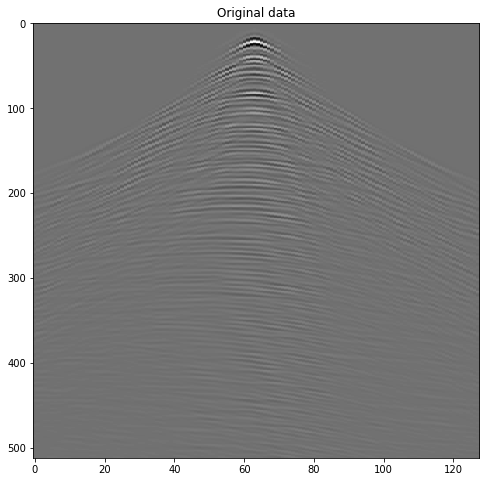

In [3]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(D,cmap='gray',aspect='auto')
ax.set_title('Original data')

In [4]:
# frqeuncy spectrum
F = pylops.signalprocessing.FFT2D(dims=(nt,nr),nffts=(nt,nr))

# Here cannot use reshape in column-wise, which is different from that of Matlab
fre = F*D.flatten()
D_adjF = F.H*fre

fre = (fre.reshape(nt, nr,order='C')) # undo the scailing
fre_shift = np.fft.fftshift(fre)

fre_np = np.fft.fftshift(np.fft.fft2(D))
fre_np_sqz = fre_np.reshape(-1,order='C')

# Jitterred subsampling

In [5]:
# relocation sampling(curvatural focus)
# focus zone [40 80]
s_min = 40
s_max= 80

interval_d = 2
interval_s = 6
node_s1 = np.arange(0,s_min,interval_s)
node_s2 = np.arange(s_max,nr,interval_s)
node_d = np.arange(s_min,s_max,interval_d)
jitter_s1 = np.random.randint(interval_s,size=node_s1.size)
jitter_s1[-1] = np.random.randint(s_min - node_s1[-1])
jitter_s2 = np.random.randint(interval_s,size=node_s2.size)
jitter_s2[-1] = np.random.randint(nr - node_s2[-1])
jitter_d = np.random.randint(interval_d,size=node_d.size)
jitter_d[-1] = np.random.randint(s_max - node_d[-1])

jitter = np.concatenate((node_s1+jitter_s1,node_d+jitter_d,node_s2+jitter_s2),axis=None)

cod = np.arange(0,nt*nr).reshape(nt,nr)
idx = cod[:,jitter].flatten()

R = pylops.Restriction(N, idx)
D_dec = R*D_sqz
D_adj = R.H*D_dec

#divide the restriction matrix into two parts(left and right,
# but both share the same 'middle part')
jitter_left = np.concatenate((node_s1+jitter_s1,node_d+jitter_d),axis=None)
jitter_right = np.concatenate((node_d+jitter_d,node_s2+jitter_s2),axis=None) - s_min

cod_left = np.arange(0,nt*s_max).reshape(nt,s_max)
cod_right = np.arange(0,nt*(nr-s_min)).reshape(nt,nr-s_min)

idx_left = cod_left[:,jitter_left].flatten()
idx_right = cod_right[:,jitter_right].flatten()

R_left = pylops.Restriction(nt*s_max, idx_left)
R_right = pylops.Restriction(nt*(nr-s_min), idx_right)

D_left = D[:,np.arange(0,s_max)]
D_right = D[:,np.arange(s_min,nr)]
nt,nr_right = D_right.shape
nt,nr_left = D_left.shape

Text(0.5, 1.0, 'Adjoint recovery')

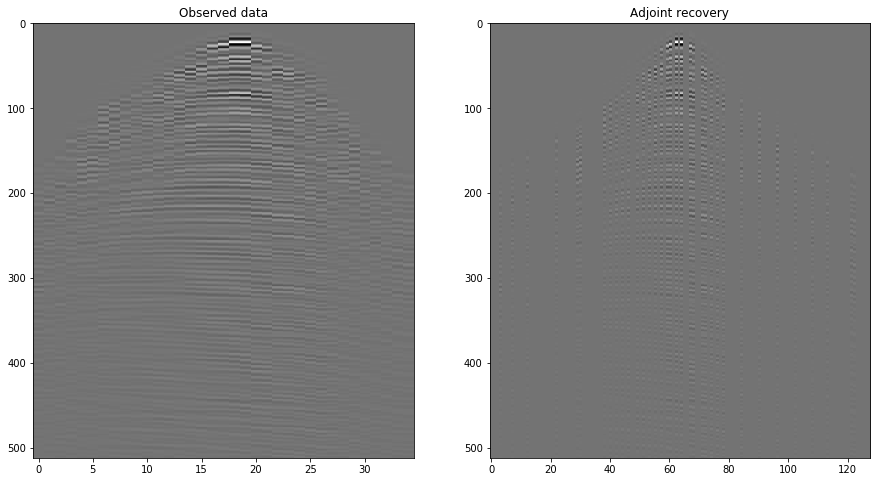

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(15, 8))
axs[0].imshow(D_dec.reshape(nt,jitter.size,order='C'),cmap='gray',aspect='auto')
axs[0].set_title('Observed data')
axs[1].imshow(D_adj.reshape(nt,nr,order='C'),cmap='gray',aspect='auto')
axs[1].set_title('Adjoint recovery')

# Calculating derivatives

In [7]:
# calculate derivatives from original data
# by hand
fre_sqz = F*D.flatten()

dx=10
kn=1/(2*dx)
dk=2*kn/nr
ks = np.arange(-kn,kn,dk)
ka = np.where(ks>0)
ka = ka[0]
ks_pos = ks[ka[0]:]
ks_neg = ks[0:ka[0]]
ks = np.concatenate((ks_pos,ks_neg))

dt=5e-3
fn=1/(2*dt)

coeff1 = 1j*2*np.pi*ks
coeff2 = -(2*np.pi*ks)**2

coeff1_m = np.tile(coeff1,nt)
coeff2_m = np.tile(coeff2,nt)

D1op_hand = pylops.Diagonal(coeff1_m)
D2op_hand = pylops.Diagonal(coeff2_m)

D1_hand_fre = D1op_hand*fre_sqz
D2_hand_fre = D2op_hand*fre_sqz

D1_hand = F.H*D1_hand_fre
D2_hand = F.H*D2_hand_fre

In [8]:
# calculate derivatives for both sides
F_left = pylops.signalprocessing.FFT2D(dims=(nt,s_max),nffts=(nt,s_max))
F_right = pylops.signalprocessing.FFT2D(dims=(nt,nr-s_min),nffts=(nt,nr-s_min))
fre_left = F_left*D_left.flatten()
fre_right = F_right*D_right.flatten()

# left side
dx=1
kn=1/(2*dx)
dk=2*kn/nr_left
ks = np.arange(-kn,kn,dk)
ka = np.where(ks>0)
ka = ka[0]
ks_pos = ks[ka[0]:]
ks_neg = ks[0:ka[0]]
ks = np.concatenate((ks_pos,ks_neg))

dt=1e-2
fn=1/(2*dt)

coeff1 = 1j*2*np.pi*ks
coeff2 = -(2*np.pi*ks)**2

coeff1_m = np.tile(coeff1,nt)
coeff2_m = np.tile(coeff2,nt)

D1op_hand_left = pylops.Diagonal(coeff1_m)
D2op_hand_left = pylops.Diagonal(coeff2_m)

D1_hand_fre = D1op_hand_left*fre_left
D2_hand_fre = D2op_hand_left*fre_left

D1_hand_left = F_left.H*D1_hand_fre
D2_hand_left = F_left.H*D2_hand_fre

# right side
dx=1
kn=1/(2*dx)
dk=2*kn/nr_right
ks = np.arange(-kn,kn,dk)
ka = np.where(ks>0)
ka = ka[0]
ks_pos = ks[ka[0]:]
ks_neg = ks[0:ka[0]]
ks = np.concatenate((ks_pos,ks_neg))

dt=1e-2
fn=1/(2*dt)

coeff1 = 1j*2*np.pi*ks
coeff2 = -(2*np.pi*ks)**2

coeff1_m = np.tile(coeff1,nt)
coeff2_m = np.tile(coeff2,nt)

D1op_hand_right = pylops.Diagonal(coeff1_m)
D2op_hand_right = pylops.Diagonal(coeff2_m)

D1_hand_fre = D1op_hand_right*fre_right
D2_hand_fre = D2op_hand_right*fre_right

D1_hand_right = F_right.H*D1_hand_fre
D2_hand_right = F_right.H*D2_hand_fre

## Musk in Fourier domain

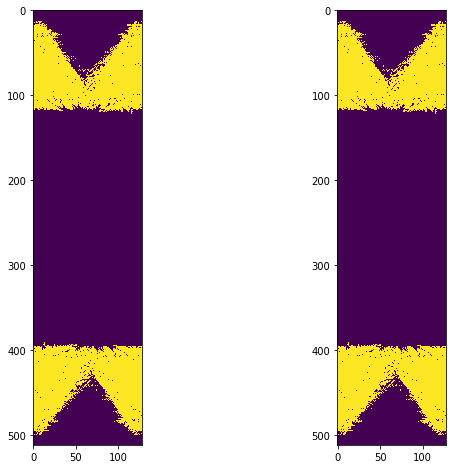

In [9]:
fre = np.abs(F*D.flatten())
condition = fre > 3
mat =condition.astype(int)
musk = pylops.Diagonal(mat)

mat_show = mat.reshape(nt,nr)

ones = np.ones((nt,nr))
test = musk*ones.flatten()
test_adj = musk.H*test
test = test.reshape(nt,nr)
test_adj = test_adj.reshape(nt,nr)

fig,axes = plt.subplots(1,2,figsize=(10,8))
axes[0].imshow(test)
axes[1].imshow(test_adj)


# Construction & solving of the linear system

In [10]:
# solve the linear equations
D2_dec = np.real(R*(D2_hand))
D1_dec = np.real(R*(D1_hand))

# # Divide the samples into 2 parts
left_range = np.arange(0,80,1)
right_range = np.arange(40,nr,1)
D2_dec_right = R_right*D2_hand_right
D1_dec_right = R_right*D1_hand_right
D_dec_right = R_right*D_right.flatten()
D2_dec_left = R_left*D2_hand_left
D1_dec_left = R_left*D1_hand_left
D_dec_right = R_left*D_left.flatten()

D_dec_left = R_left*D_left.flatten()
D_dec_right = R_right*D_right.flatten()

# solve in time domain

Forward_left = pylops.VStack([R_left*F_left.H, R_left*F_left.H*D1op_hand_left, R_left*F_left.H*D2op_hand_left])
rhs_left = np.concatenate((D_dec_left, D1_dec_left, D2_dec_left), axis=0)

Forward_right = pylops.VStack([R_right*F_right.H, R_right*F_right.H*D1op_hand_right, R_right*F_right.H*D2op_hand_right])
rhs_right = np.concatenate((D_dec_right, D1_dec_right, D2_dec_right), axis=0)

Forward2 = pylops.VStack([R*F.H, R*F.H*D1op_hand, R*F.H*D2op_hand])
rhs2 = np.concatenate((D_dec, D1_dec, D2_dec), axis=0)

In [11]:
# xspgl1, pspgl1, info1 = SPGL1(Forward, rhs, returninfo=True, 
#                              **dict(iterations=400))

xinv, pspgl1, info1 = SPGL1(Forward_left, rhs_left,returninfo=True, 
                             **dict(iterations=200))
xinv2, pspgl2, info2 = SPGL1(Forward_right, rhs_right,returninfo=True, 
                             **dict(iterations=200))
xinv = np.real(F_left.H*xinv).reshape(nt,s_max)
xinv2 = np.real(F_right.H*xinv2).reshape(nt,nr-s_min)
xinv_re = np.concatenate((xinv[:,np.arange(0,s_min)],xinv2),axis=1)
sigma = np.linalg.norm(rhs2 - (Forward2*xinv_re.flatten()))

xinv3, pspgl3, info3 = SPGL1(Forward2, rhs2,sigma,returninfo=True, 
                             **dict(iterations=800))
xinv3 = np.real(F.H*xinv3).reshape(nt,nr)




/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pylops/basicoperators/Restriction.py:44: ComplexWarning: Casting complex values to real discards the imaginary part
  y[self.iava] = x


In [12]:
print(sigma)
print(info1['stat'],info1['rNorm'])
print(info2['stat'],info2['rNorm'])
print(info3['stat'],info3['rNorm'])

3922.839634047258
5 1003.1790352147572
5 2007.158937647854
6 597.4316041185652


Text(0.5, 1.0, 'RIGHT--solve in Fourier domain')

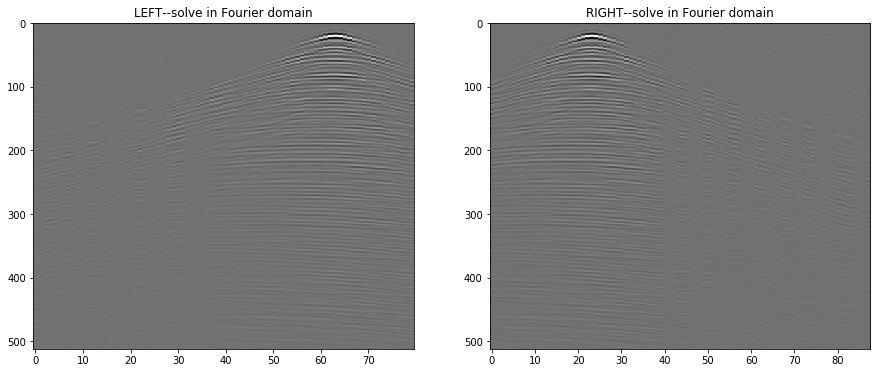

In [13]:
# reconstruction results

fig, axs = plt.subplots(1, 2, figsize=(15, 6))
axs[0].imshow(np.real(xinv),cmap='gray',aspect='auto')
axs[0].set_title('LEFT--solve in Fourier domain')
axs[1].imshow(np.real(xinv2),cmap='gray',aspect='auto')
axs[1].set_title('RIGHT--solve in Fourier domain')

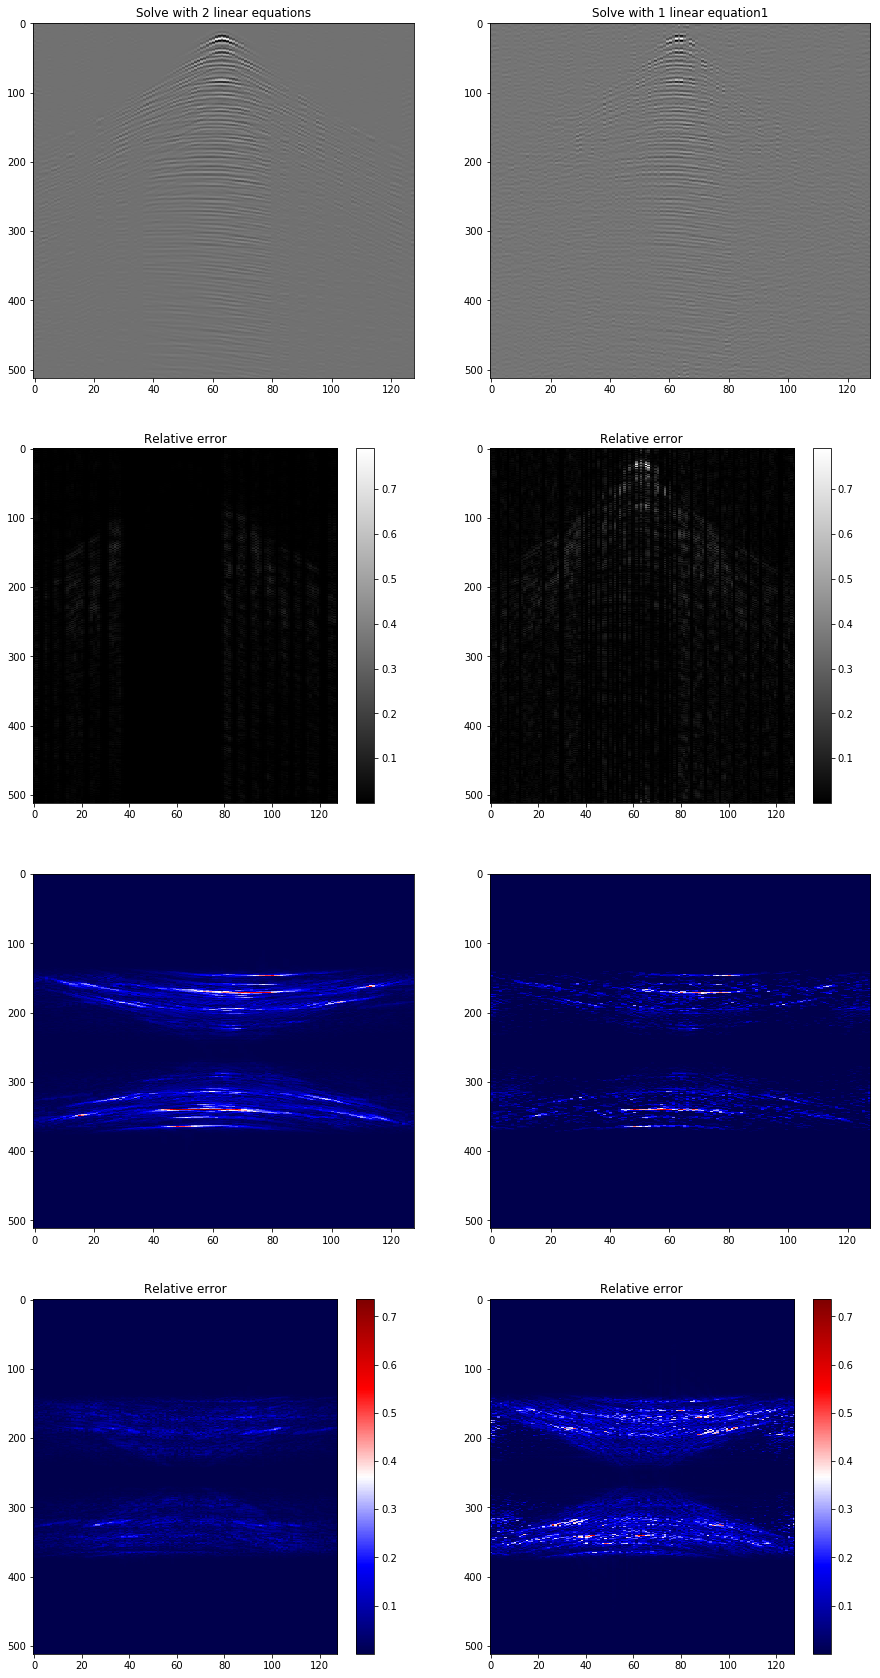

In [14]:
xinv = xinv_re.copy() # solve in 2 equations
xinv2 = xinv3.copy() # solve in only 1 equation

xinv_fre = np.fft.fftshift(np.fft.fft2(xinv))
xinv2_fre = np.fft.fftshift(np.fft.fft2(xinv2))

relative = np.abs((xinv - D) / np.amax(D))
relative2 = np.abs((xinv2 - D) / np.amax(D))

relative_fre = np.abs((xinv_fre - fre_np) / np.amax(fre_np))
relative2_fre = np.abs((xinv2_fre - fre_np) / np.amax(fre_np))

combined_data = np.array([relative,relative2])
t_min, t_max = np.amin(combined_data), np.amax(combined_data)

combined_data = np.array([relative_fre,relative2_fre])
f_min, f_max = np.amin(combined_data), np.amax(combined_data)

fig, axs = plt.subplots(4, 2, figsize=(15, 30))
axs[0,0].imshow(np.real(xinv),cmap='gray',aspect='auto')
axs[0,0].set_title('Solve with 2 linear equations')
axs[0,1].imshow(np.real(xinv2),cmap='gray',aspect='auto')
axs[0,1].set_title('Solve with 1 linear equation1')
im1 = axs[1,0].imshow(relative,cmap='gray',aspect='auto',vmin=t_min, vmax =t_max)
im2 = axs[1,1].imshow(relative2,cmap='gray',aspect='auto',vmin=t_min, vmax =t_max)
fig.colorbar(im1,ax=axs[1,0])
fig.colorbar(im2,ax=axs[1,1])
axs[1,0].set_title('Relative error')
axs[1,1].set_title('Relative error')
axs[2,0].imshow(np.abs(xinv_fre),cmap='seismic',aspect='auto')
axs[2,1].imshow(np.abs(xinv2_fre),cmap='seismic',aspect='auto')
im3 = axs[3,0].imshow(relative_fre,cmap='seismic',aspect='auto',vmin=f_min, vmax =f_max)
im4 = axs[3,1].imshow(relative2_fre,cmap='seismic',aspect='auto',vmin=f_min, vmax =f_max)
axs[3,0].set_title('Relative error')
axs[3,1].set_title('Relative error')
fig.colorbar(im3,ax=axs[3,0])
fig.colorbar(im4,ax=axs[3,1])